In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import pickle
import os
from collections import Counter

In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use Tensorflow version 1.0 or newer. You are using {}'.format(tf.__version__)
print('Tensorflow Version: {}'.format(tf.__version__))

# Check for GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Tensorflow Version: 2.2.0-rc2
Default GPU Device: /device:GPU:0


In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from keras_bert import load_trained_model_from_checkpoint

Using TensorFlow backend.


In [4]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

In [5]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
# from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [6]:
# import packages
import pickle
from gensim.models import KeyedVectors
import numpy as np
from itertools import chain
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Lambda, merge, Input, Reshape, Embedding, Dropout, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Flatten, TimeDistributed,Concatenate
from keras.optimizers import RMSprop
from keras.models import Model
from keras.layers import Conv1D, ThresholdedReLU, MaxPooling1D, Activation, concatenate # TimeDistributedDense
from keras.initializers import RandomUniform
from keras_contrib.layers import CRF
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.callbacks import EarlyStopping
import time
import datetime
from keras.engine.topology import Layer
import tensorflow as tf
import random, os, sys
import numpy as np
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *

import skopt
# !pip install scikit-optimize if  necessary
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  

import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow
from tensorflow.python.keras import backend as K

from keras.engine.topology import Layer

import pickle
import nltk
import itertools
import numpy as np
import pandas as pd
import re
from operator import itemgetter
from itertools import *
import matplotlib.pyplot as plt
import collections
import seaborn as sns

from keras.utils import CustomObjectScope
# from DAR_model import HierarchicalAttentionNetwork

from keras.preprocessing.sequence import pad_sequences


import tensorflow as tf
from tensorflow.keras import backend as K

from keras.models import Model, load_model
from keras_contrib.layers import CRF

from collections import Counter

## Data

In [7]:
#--------------------------------------------------------------------------------#
#                            SwDA
#--------------------------------------------------------------------------------#

# load all data necessary for training
data_dir =  "C://Users//31642//anaconda3//envs//thesis_dar//KimThesis//processed_data/SwDA/"

# load metadata
metadata_swda = pickle.load(open(data_dir + "metadata.pkl", "rb"))

# load training, test and validation sets
train_x_swda =  pickle.load(open(data_dir + "train_x.pkl", "rb"))
train_y_swda = pickle.load(open(data_dir + "train_y.pkl", "rb"))

test_x_swda = pickle.load(open(data_dir + "test_x.pkl", "rb"))
test_y_swda = pickle.load(open(data_dir + "test_y.pkl", "rb"))

valid_x_swda = pickle.load(open(data_dir + "valid_x.pkl", "rb"))
valid_y_swda = pickle.load(open(data_dir + "valid_y.pkl", "rb"))

# load training, test and validation sets made for character embeddings
train_char_x_swda =  pickle.load(open(data_dir + "train_char_x.pkl", "rb"))
test_char_x_swda =  pickle.load(open(data_dir + "test_char_x.pkl", "rb"))
valid_char_x_swda =  pickle.load(open(data_dir + "valid_char_x.pkl", "rb"))


#--------------------------------------------------------------------------------#
#                            MRDA
#--------------------------------------------------------------------------------#
# load all data necessary for training
data_dir ="C://Users//31642//anaconda3//envs//thesis_dar//KimThesis//processed_data/MRDA/"

# load metadata
metadata_mrda = pickle.load(open(data_dir + "metadata.pkl", "rb"))

# load training, test and validation sets
train_x_mrda =  pickle.load(open(data_dir + "train_x.pkl", "rb"))
train_y_mrda = pickle.load(open(data_dir + "train_y.pkl", "rb"))

test_x_mrda = pickle.load(open(data_dir + "test_x.pkl", "rb"))
test_y_mrda = pickle.load(open(data_dir + "test_y.pkl", "rb"))

valid_x_mrda = pickle.load(open(data_dir + "valid_x.pkl", "rb"))
valid_y_mrda = pickle.load(open(data_dir + "valid_y.pkl", "rb"))

# load training, test and validation sets made for character embeddings
train_char_x_mrda =  pickle.load(open(data_dir + "train_char_x.pkl", "rb"))
test_char_x_mrda=  pickle.load(open(data_dir + "test_char_x.pkl", "rb"))
valid_char_x_mrda =  pickle.load(open(data_dir + "valid_char_x.pkl", "rb"))




In [98]:
# predictions_swda = get_predictions(model_swda, metadata_swda, test_x_swda, test_char_x_swda)
# predictions_mrda = get_predictions(model_mrda, metadata_mrda, test_x_mrda, test_char_x_mrda)

### Plot Utterance Length vs Accuracy

In [9]:
def get_plot_df(model_name, metadata, predictions, test_y, test_x):
    #max_number_utterances = metadata['max_number_utterances']
    index_to_label = metadata['index_to_label']
    label_to_index = metadata['label_to_index']
    num_da_tags = metadata['num_da_tags']

    # Predictions results
    correct = 0
    incorrect = 0
    correct_labels = {}
    incorrect_labels = {}
    index_to_label = metadata["index_to_label"]
    for i in range(len(index_to_label)):
        correct_labels[index_to_label[i]] = 0
        incorrect_labels[index_to_label[i]] = 0

    correctness = []    
    for i in range(0,len(predictions)):
        for j in range(0,len(predictions[i])):

            prediction = index_to_label[np.argmax(predictions[i][j])]
            true = index_to_label[np.argmax(test_y[i][j])]

            if prediction == true:
                correctness.append(1)
            else:
                correctness.append(0)

    utterance_len = []
    no_dialogues = len(test_x)

    for i in range(0, no_dialogues):
        dialogue = test_x[i]
        no_utterances = len(dialogue)
        for j in range(0, no_utterances):
            utterance_len.append(np.count_nonzero(dialogue[j]))

    overview = pd.DataFrame({'utterance_len': utterance_len, 'correctness': correctness})

    c = Counter(list(overview['utterance_len']))

    lenghts = list(Counter(el for el in c.elements() if c[el] >= 20).keys()) #NOTE AT LEAST 20 UTTERANCES WITH THAT LENGTH
    lenghts = sorted(lenghts)

    accuracy_overview = []

    for i in range(0,len(lenghts)):
        new_df = overview[overview['utterance_len'] == lenghts[i]]
        accuracy = sum(list(new_df['correctness'])) / len(new_df)
        accuracy_overview.append(accuracy)

    fin_acc_overview = pd.DataFrame({'utterance_len': lenghts, 'accuracy': accuracy_overview})
    
    fin_acc_overview['label'] = model_name
    
    return fin_acc_overview

def get_plot_dialogue_len(model_name, metadata, predictions, test_y, test_x):
    #max_number_utterances = metadata['max_number_utterances']
    index_to_label = metadata['index_to_label']
    label_to_index = metadata['label_to_index']
    num_da_tags = metadata['num_da_tags']

    # Predictions results
    correct = 0
    incorrect = 0
    correct_labels = {}
    incorrect_labels = {}
    index_to_label = metadata["index_to_label"]
    for i in range(len(index_to_label)):
        correct_labels[index_to_label[i]] = 0
        incorrect_labels[index_to_label[i]] = 0

    correctness = []    
    for i in range(0,len(predictions)):
        for j in range(0,len(predictions[i])):

            prediction = index_to_label[np.argmax(predictions[i][j])]
            true = index_to_label[np.argmax(test_y[i][j])]

            if prediction == true:
                correctness.append(1)
            else:
                correctness.append(0)

    no_dialogues = len(test_x)
    no_utterances = []
    for i in range(0, no_dialogues):
        dialogue = test_x[i]
        no_utterances.append(len(dialogue))

    overview_no_utterances = []
    for i in range(0,len(no_utterances)):
        extd_list = no_utterances[i] * [no_utterances[i]]
        overview_no_utterances.append(extd_list)
    
    final_overview_no_utterances = [i for sublist in overview_no_utterances for i in sublist]

    overview = pd.DataFrame({'utterance_len': final_overview_no_utterances, 'correctness': correctness})

    c = Counter(list(overview['utterance_len']))

    lenghts = list(Counter(el for el in c.elements() if c[el] >= 20).keys()) #NOTE AT LEAST 20 UTTERANCES WITH THAT LENGTH
    lenghts = sorted(lenghts)

    accuracy_overview = []

    for i in range(0,len(lenghts)):
        new_df = overview[overview['utterance_len'] == lenghts[i]]
        accuracy = sum(list(new_df['correctness'])) / len(new_df)
        accuracy_overview.append(accuracy)

    fin_acc_overview = pd.DataFrame({'utterance_len': lenghts, 'accuracy': accuracy_overview})
    
    fin_acc_overview['lael'] = model_name
    
    return fin_acc_overview

def df_for_barplots(data, model_name):
    short_conversations = [91, 99]
    moderately_long_conversations = [154, 157, 172, 183, 188, 198]
    long_conversations = [221, 225, 226, 232, 236, 243]
    very_long_conversations = [277, 294, 309, 330]
    
    avg_short = data[data['utterance_len'].isin(short_conversations)]['accuracy'].mean()
    avg_moderately_long = data[data['utterance_len'].isin(moderately_long_conversations)]['accuracy'].mean()
    avg_long = data[data['utterance_len'].isin(long_conversations)]['accuracy'].mean()
    avg_very_long = data[data['utterance_len'].isin(very_long_conversations)]['accuracy'].mean()

    df = pd.DataFrame({'Dialogue Length': ['short', 'moderately long', 'long', 'very long'],
    'Average Accuracy': [avg_short, avg_moderately_long, avg_long, avg_very_long ],
    'Method': [model_name] * 4})

    return df

In [10]:
data_dir = "C:\\Users\\31642\\anaconda3\\envs\\thesis_dar\\KimThesis\\results\\SwDA\\"
swda_predictions_pool_crf = np.load('predictions_pool_crf.npy', allow_pickle = True)
swda_predictions_att_crf = np.load('predictions_att_crf.npy', allow_pickle = True)
swda_predictions_mha_pool_crf = np.load('predictions_mha_pool_crf.npy', allow_pickle = True)
swda_predictions_mha_att_crf = np.load('predictions_mha_att_crf.pkl', allow_pickle = True)
swda_predictions_pool_2rnn = np.load('predictions_pool_2rnn.pkl', allow_pickle = True)
swda_predictions_att_2rnn = np.load('predictions_att_2rnn.pkl', allow_pickle = True)
swda_predictions_bert_crf = np.load('predictions_bert_crf.pkl', allow_pickle = True)
swda_predictions_bert_2rnn = np.load('predictions_bert_2rnn.pkl', allow_pickle = True)
swda_predictions_r_t = np.load('predictions_r_t.pkl', allow_pickle = True)
swda_predictions_mha_csa_crf = np.load('predictions_mha_csa_crf.pkl', allow_pickle = True)
swda_predictions_csa_2rnn = np.load('predictions_csa_2rnn.pkl', allow_pickle = True)



data_dir = "C:\\Users\\31642\\anaconda3\\envs\\thesis_dar\\KimThesis\\results\\MRDA\\"
mrda_predictions_pool_crf = np.load('predictions_pool_crf.npy', allow_pickle = True)
mrda_predictions_att_crf = np.load('predictions_att_crf.npy', allow_pickle = True)
mrda_predictions_mha_pool_crf = np.load('predictions_mha_pool_crf.npy', allow_pickle = True)
mrda_predictions_mha_att_crf = np.load('predictions_mha_att_crf.pkl', allow_pickle = True)
mrda_predictions_pool_2rnn = np.load('predictions_pool_2rnn.pkl', allow_pickle = True)
mrda_predictions_att_2rnn = np.load('predictions_att_2rnn.pkl', allow_pickle = True)
mrda_predictions_bert_crf = np.load('predictions_bert_crf.pkl', allow_pickle = True)
mrda_predictions_bert_2rnn = np.load('predictions_bert_2rnn.pkl', allow_pickle = True)
mrda_predictions_r_t = np.load('predictions_r_t.pkl', allow_pickle = True)
mrda_predictions_mha_csa_crf = np.load('predictions_mha_csa_crf.pkl', allow_pickle = True)
mrda_predictions_csa_2rnn = np.load('predictions_csa_2rnn.pkl', allow_pickle = True)


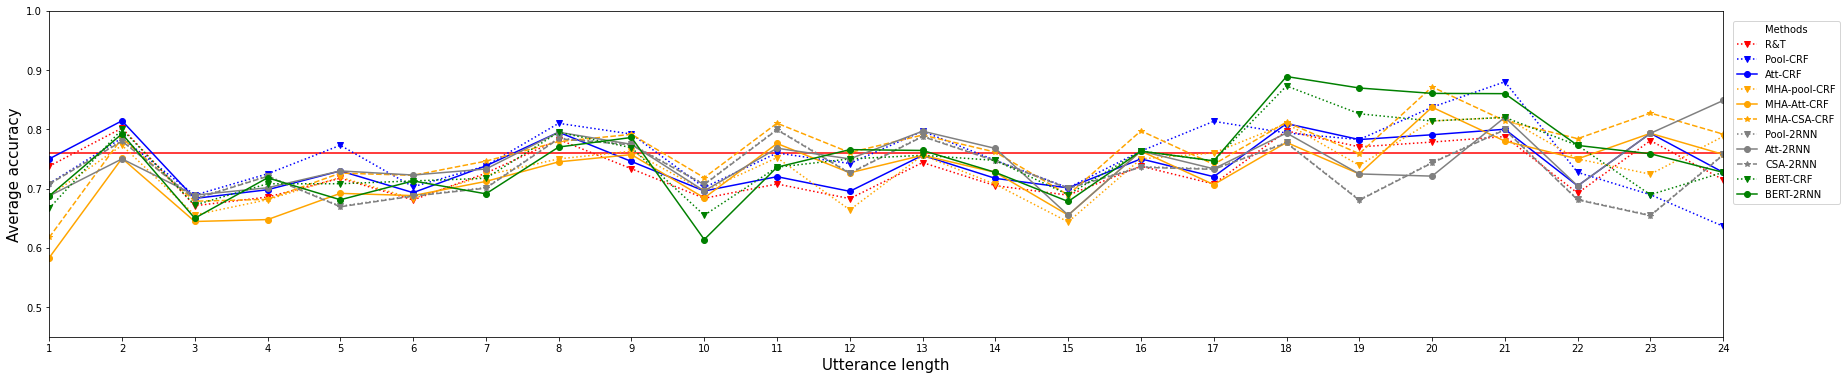

In [100]:
# Utterance level SwDA
swda_utterance_pool_lstm_crf = get_plot_df('pool-LSTM-CRF', metadata_swda, swda_predictions_pool_crf, test_y_swda, test_x_swda)
swda_utterance_pool_2lstm = get_plot_df('pool-2LSTM', metadata_swda,  swda_predictions_pool_2rnn, test_y_swda, test_x_swda)
swda_utterance_pool_mha_crf = get_plot_df('pool-MHA-CRF', metadata_swda,  swda_predictions_mha_pool_crf, test_y_swda, test_x_swda)
swda_utterance_ha_lstm_crf = get_plot_df('HA-LSTM-CRF', metadata_swda,  swda_predictions_att_crf, test_y_swda, test_x_swda)
swda_utterance_ha_2lstm = get_plot_df('HA-2LSTM', metadata_swda,  swda_predictions_att_2rnn, test_y_swda, test_x_swda)
swda_utterance_ha_mha_crf = get_plot_df('HA-MHA-CRF', metadata_swda,  swda_prediction_ha_mha_crf, test_y_swda, test_x_swda)
swda_utterance_bert_lstm_crf = get_plot_df('BERT-LSTM-CRF', metadata_swda,  swda_predictions_bert_2rnn, test_y_swda, test_x_swda)
swda_utterance_bert_2lstm = get_plot_df('BERT-2LSTM', metadata_swda,  swda_predictions_bert_2rnn, test_y_swda, test_x_swda)
swda_utterance_r_t = get_plot_df('R&T', metadata_swda,  swda_predictions_r_t, test_y_swda, test_x_swda)
swda_utterance_mha_csa_crf = get_plot_df('MHA-CSA-CRF', metadata_swda,  swda_predictions_mha_csa_crf, test_y_swda, test_x_swda)
swda_utterance_csa_2rnn = get_plot_df('CSA-2rnn', metadata_swda,  swda_predictions_csa_2rnn, test_y_swda, test_x_swda)



plt.figure(figsize=(30,6))

plt.plot(r_t['utterance_len'], r_t['accuracy'], 'v:', color = 'red', label = 'R&T')
plt.plot(swda_utterance_pool_lstm_crf['utterance_len'], swda_utterance_pool_lstm_crf['accuracy'],'v:', color='blue',  label = 'Pool-CRF')
plt.plot(swda_utterance_ha_lstm_crf['utterance_len'], swda_utterance_ha_lstm_crf['accuracy'], 'o-', color = 'blue', label = 'Att-CRF')
plt.plot(swda_utterance_pool_mha_crf['utterance_len'], swda_utterance_pool_mha_crf['accuracy'], 'v:', color = 'orange', label = 'MHA-pool-CRF')
plt.plot(swda_utterance_ha_mha_crf['utterance_len'], swda_utterance_ha_mha_crf['accuracy'], 'o-', color = 'orange', label = 'MHA-Att-CRF')
plt.plot(mha_csa_crf['utterance_len'], mha_csa_crf['accuracy'], '*--', color = 'orange', label = 'MHA-CSA-CRF')
plt.plot(swda_utterance_pool_2lstm['utterance_len'], swda_utterance_pool_2lstm['accuracy'], 'v:', color = 'grey', label = 'Pool-2RNN')
plt.plot(swda_utterance_ha_2lstm['utterance_len'], swda_utterance_ha_2lstm['accuracy'], 'o-', color = 'grey', label = 'Att-2RNN')
plt.plot(csa_2rnn['utterance_len'], csa_2rnn['accuracy'], '*--', color = 'grey', label = 'CSA-2RNN')
plt.plot(swda_utterance_bert_lstm_crf['utterance_len'], swda_utterance_bert_lstm_crf['accuracy'], 'v:', color = 'green', label = 'BERT-CRF')
plt.plot(swda_utterance_bert_2lstm['utterance_len'], swda_utterance_bert_2lstm['accuracy'], 'o-', color = 'green', label = 'BERT-2RNN')


# plt.legend(title='Methods')
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1., title = 'Methods')
plt.xticks(np.array(list(swda_utterance_pool_lstm_crf['utterance_len'])))
plt.xlabel('Utterance length',fontsize = 15)
plt.ylabel('Average accuracy',fontsize = 15)
#plt.title('SwDA corpus')
plt.xlim(1,24)
plt.hlines(0.7604, 1, 24, colors = 'red')
plt.ylim(0.45,1.0)
plt.savefig('utternce_len_swda.png')



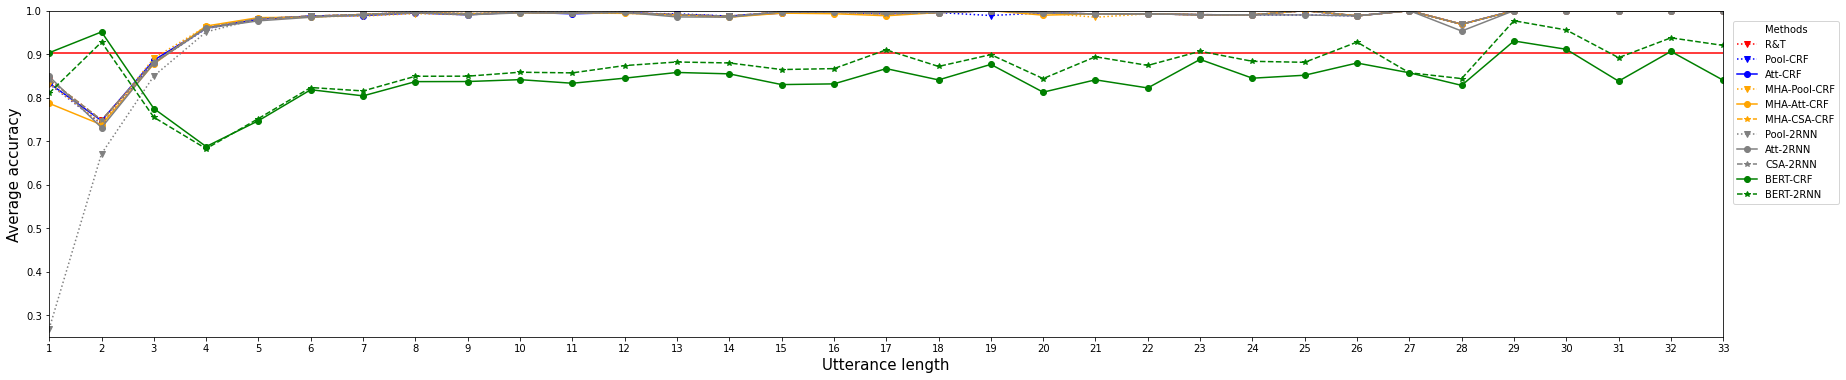

In [101]:
# Utterance level
mrda_utterance_pool_lstm_crf = get_plot_df('pool-LSTM-CRF', metadata_mrda, mrda_predictions_pool_crf, test_y_mrda, test_x_mrda)
mrda_utterance_pool_2lstm = get_plot_df('pool-2LSTM', metadata_mrda, mrda_predictions_pool_2rnn, test_y_mrda, test_x_mrda)
mrda_utterance_pool_mha_crf = get_plot_df('pool-MHA-CRF', metadata_mrda,  mrda_predictions_mha_pool_crf, test_y_mrda, test_x_mrda)
mrda_utterance_ha_lstm_crf = get_plot_df('HA-LSTM-CRF', metadata_mrda,  mrda_predictions_att_crf, test_y_mrda, test_x_mrda)
mrda_utterance_ha_2lstm = get_plot_df('HA-2LSTM', metadata_mrda,  mrda_predictions_att_2rnn, test_y_mrda, test_x_mrda)
mrda_utterance_ha_mha_crf = get_plot_df('HA-MHA-CRF', metadata_mrda,  mrda_prediction_ha_mha_crf, test_y_mrda, test_x_mrda)
mrda_utterance_bert_lstm_crf = get_plot_df('BERT-LSTM-CRF', metadata_mrda, mrda_predictions_bert_crf, test_y_mrda, test_x_mrda)
mrda_utterance_bert_2lstm = get_plot_df('BERT-2LSTM', metadata_mrda,  mrda_predictions_bert_2rnn, test_y_mrda, test_x_mrda)
mrda_utterance_r_t = get_plot_df('R&T', metadata_swda,  mrda_predictions_r_t, test_y_swda, test_x_swda)
mrda_utterance_mha_csa_crf = get_plot_df('MHA-CSA-CRF', metadata_swda,  mrda_predictions_mha_csa_crf, test_y_swda, test_x_swda)
mrda_utterance_csa_2rnn = get_plot_df('CSA-2rnn', metadata_swda,  mrda_predictions_csa_2rnn, test_y_swda, test_x_swda)



plt.figure(figsize=(30,6))
plt.plot(mrda_utterance_r_t['utterance_len'], mrda_utterance_r_t['accuracy'], 'v:', color = 'red', label = 'R&T')
plt.plot(mrda_utterance_pool_lstm_crf['utterance_len'], mrda_utterance_pool_lstm_crf['accuracy'],'v:', color='blue',  label = 'Pool-CRF')
plt.plot(mrda_utterance_ha_lstm_crf['utterance_len'], mrda_utterance_ha_lstm_crf['accuracy'], 'o-', color = 'blue', label = 'Att-CRF')
plt.plot(mrda_utterance_pool_mha_crf['utterance_len'], mrda_utterance_pool_mha_crf['accuracy'], 'v:', color = 'orange', label = 'MHA-Pool-CRF')
plt.plot(mrda_utterance_ha_mha_crf['utterance_len'], mrda_utterance_ha_mha_crf['accuracy'], 'o-', color = 'orange', label = 'MHA-Att-CRF')
plt.plot(mrda_utterance_r_t['utterance_len'], mrda_utterance_r_t['accuracy'], '*--', color = 'orange', label = 'MHA-CSA-CRF')
plt.plot(mrda_utterance_pool_2lstm['utterance_len'], mrda_utterance_pool_2lstm['accuracy'], 'v:', color = 'grey', label = 'Pool-2RNN')
plt.plot(mrda_utterance_ha_2lstm['utterance_len'], mrda_utterance_ha_2lstm['accuracy'], 'o-', color = 'grey', label = 'Att-2RNN')
plt.plot(mrda_utterance_r_t['utterance_len'], mrda_utterance_r_t['accuracy'], '*--', color = 'grey', label = 'CSA-2RNN')
plt.plot(mrda_utterance_bert_lstm_crf['utterance_len'], mrda_utterance_bert_lstm_crf['accuracy'], 'o-', color = 'green', label = 'BERT-CRF')
plt.plot(mrda_utterance_bert_2lstm['utterance_len'], mrda_utterance_bert_2lstm['accuracy'], '*--', color = 'green', label = 'BERT-2RNN')


plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1., title = 'Methods')
plt.xticks(np.array(list(mrda_utterance_pool_lstm_crf['utterance_len'])))
plt.xlabel('Utterance length',fontsize = 15)
plt.ylabel('Average accuracy',fontsize = 15)
#plt.title('MRDA corpus')
plt.xlim(1,33)
plt.ylim(0.25,1)
plt.hlines(0.9027, 1, 33, colors = 'red')
plt.savefig('utterance_len_mrda.png')




## Plot dialogue length

In [59]:
# Dialogue level
swda_dialogue_pool_lstm_crf = get_plot_dialogue_len('pool-LSTM-CRF', metadata_swda, swda_predictions_pool_crf, test_y_swda, test_x_swda)
swda_dialogue_pool_2lstm = get_plot_dialogue_len('pool-2LSTM', metadata_swda,  swda_predictions_att_crf, test_y_swda, test_x_swda)
swda_dialogue_pool_mha_crf = get_plot_dialogue_len('pool-MHA-CRF', metadata_swda,  swda_predictions_mha_pool_crf, test_y_swda, test_x_swda)
swda_dialogue_ha_lstm_crf = get_plot_dialogue_len('HA-LSTM-CRF', metadata_swda,  swda_predictions_mha_att_crf, test_y_swda, test_x_swda)
swda_dialogue_ha_2lstm = get_plot_dialogue_len('HA-2LSTM', metadata_swda,  swda_prediction_ha_mha_crf, test_y_swda, test_x_swda)
swda_dialogue_ha_mha_crf = get_plot_dialogue_len('HA-MHA-CRF', metadata_swda,  swda_predictions_pool_2rnn, test_y_swda, test_x_swda)
swda_dialogue_bert_lstm_crf = get_plot_dialogue_len('BERT-LSTM-CRF', metadata_swda,  swda_predictions_att_2rnn, test_y_swda, test_x_swda)
swda_dialogue_bert_2lstm = get_plot_dialogue_len('BERT-2LSTM', metadata_swda,  swda_predictions_bert_crf, test_y_swda, test_x_swda)
swda_dialogue_bert_r_t = get_plot_dialogue_len('BERT-2LSTM', metadata_swda,  swda_predictions_bert_2rnn, test_y_swda, test_x_swda)
swda_dialogue_bert_mha_csa_crf = get_plot_dialogue_len('BERT-2LSTM', metadata_swda,  swda_predictions_r_t, test_y_swda, test_x_swda)
swda_dialogue_bert_csa_2rnn = get_plot_dialogue_len('BERT-2LSTM', metadata_swda,  swda_predictions_mha_csa_crf, test_y_swda, test_x_swda)



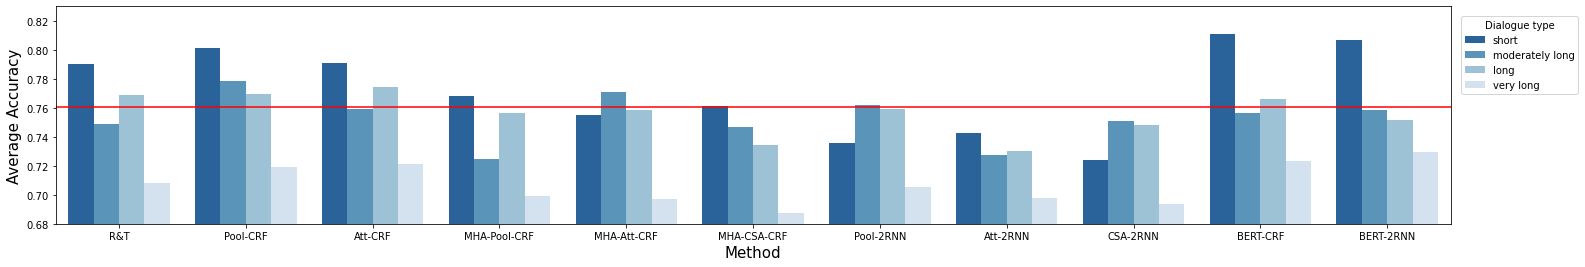

In [218]:
df1 = df_for_barplots(swda_dialogue_pool_lstm_crf, 'Pool-CRF')
df2 = df_for_barplots(swda_dialogue_pool_2lstm, 'Pool-2RNN')
df3 = df_for_barplots(swda_dialogue_pool_mha_crf, 'MHA-Pool-CRF')
df4 = df_for_barplots(swda_dialogue_ha_lstm_crf, 'Att-CRF')
df5 = df_for_barplots(swda_dialogue_ha_2lstm, 'Att-2RNN')
df6 = df_for_barplots(swda_dialogue_ha_mha_crf, 'MHA-Att-CRF')
df7 = df_for_barplots(swda_dialogue_bert_lstm_crf, 'BERT-CRF')
df8 = df_for_barplots(swda_dialogue_bert_2lstm, 'BERT-2RNN')
df9 = df_for_barplots(r_t, 'R&T')
df10 = df_for_barplots(mha_csa_crf, 'MHA-CSA-CRF')
df11 = df_for_barplots(csa_2rnn, 'CSA-2RNN')

df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11])

order = ['R&T','Pool-CRF','Att-CRF', 'MHA-Pool-CRF', 'MHA-Att-CRF', 'MHA-CSA-CRF','Pool-2RNN',  'Att-2RNN','CSA-2RNN',  'BERT-CRF', 'BERT-2RNN']


plt.figure(figsize=(25,4))
sns.barplot(df['Method'], df['Average Accuracy'], hue = df['Dialogue Length'], palette='Blues_r', order = order)
# plt.title('SwDA corpus')
plt.ylabel('Average Accuracy', fontsize = 15)
plt.xlabel('Method', fontsize = 15)
plt.xlim(-0.5,10.5)
plt.hlines(0.7604, -0.5,10.5, color = 'red')
plt.ylim(0.68,0.83)
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1., title = 'Dialogue type')
plt.savefig('barplot_per_dialog_type.png')

### Scatter Plots

In [16]:
from sklearn.manifold import TSNE

In [17]:
label_dict = {
    'sd': 'Statement-non-opinion', 'b': 'Acknowledge (Backchannel)', 'sv': 'Statement-opinion', '%': 'Uninterpretable', 'aa': 'Agree/Accept',
    'ba': 'Appreciation', 'qy': 'Yes-No-Question', 'ny': 'Yes Answers', 'fc': 'Conventional-closing', 'qw': 'Wh-Question', 'nn': 'No Answers',
    'bk': 'Response Acknowledgement', 'h': 'Hedge', 'qy^d': 'Declarative Yes-No-Question', 'bh': 'Backchannel in Question Form', '^q': 'Quotation',
    'bf': 'Summarize/Reformulate', 'fo_o_fw_"_by_bc': 'Other', 'na': 'Affirmative Non-yes Answers', 'ad': 'Action-directive', '^2': 'Collaborative Completion',
    'b^m': 'Repeat-phrase','qo': 'Open-Question', 'qh': 'Rhetorical-Question', '^h': 'Hold Before Answer/Agreement', 'ar': 'Reject', 'ng': 'Negative Non-no Answers',
    'br': 'Signal-non-understanding', 'no': 'Other Answers', 'fp': 'Conventional-opening', 'qrr': 'Or-Clause', 'arp_nd': 'Dispreffered Answers', 't3': '3rd-party-talk',
    'oo_co_cc': 'Offers, Options, Commits','aap_am': 'Maybe/Accept-part', 't1': 'Downplayer','bd': 'Self-talk','^g': 'Tag-Question','qw^d': 'Declarative Wh-Question',
    'fa': 'Apology', 'ft': 'Thanking'
    }

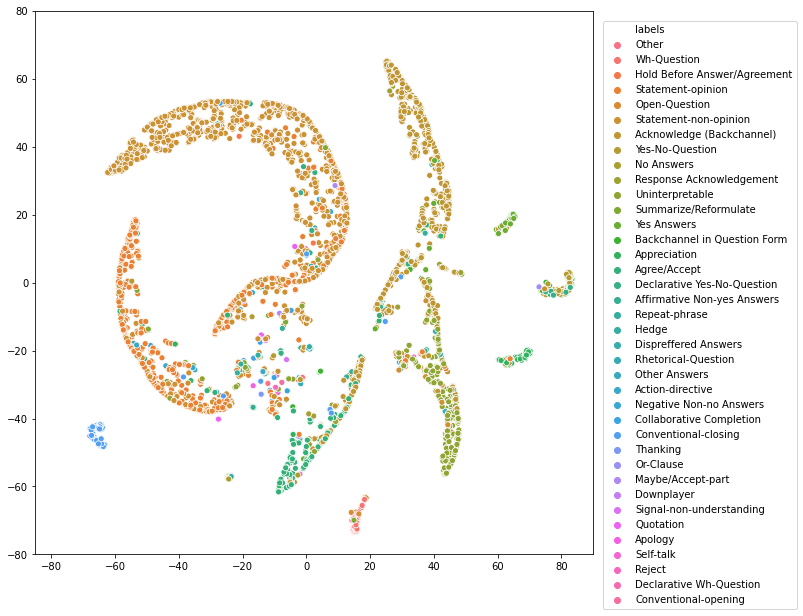

In [32]:
swda_best_model = swda_predictions[0]

all_predictions = swda_best_model[0]
for i in range(1,len(swda_best_model)):
    all_predictions = np.concatenate([all_predictions, swda_best_model[i]])
    
X_embedded = TSNE(n_components = 2).fit_transform(all_predictions)

labels = []
index_to_label = metadata_swda['index_to_label']

for j in range(0,len(test_y_swda)):
    for i in range(0,len(test_y_swda[j])):
        labels.append(index_to_label[np.argmax(test_y_swda[j][i])])
        
df_scatter_swda = pd.DataFrame({'x_axis': X_embedded[:,0],
'y_axis': X_embedded[:,1],
'labels': (pd.Series(labels)).map(label_dict)})

plt.figure(figsize=(10,10))
sns.scatterplot(df_scatter_swda['x_axis'], df_scatter_swda['y_axis'], hue=df_scatter_swda['labels'])
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.xlim(-85,90)
plt.ylim(-80,80)
plt.xlabel('')
plt.ylabel('')
plt.savefig('swda_scatter.png',bbox_inches='tight')

In [212]:
da_dict = {
    'B': 'BackChannel',
    'S': 'Statement',
    'Q': 'Question',
    'D': 'Disruption',
    'F': 'FloorGrabber'
    }

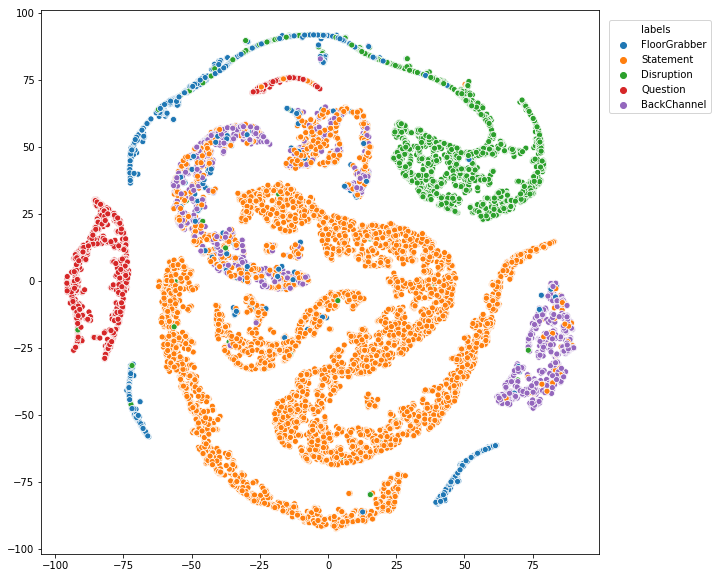

In [87]:
mrda_best_model = mrda_predictions[0]

all_predictions = mrda_best_model[0]
for i in range(1,len(mrda_best_model)):
    all_predictions = np.concatenate([all_predictions, mrda_best_model[i]])
    
X_embedded = TSNE(n_components = 2).fit_transform(all_predictions)

labels = []
index_to_label = metadata_mrda['index_to_label']

for j in range(0,len(test_y_mrda)):
    for i in range(0,len(test_y_mrda[j])):
        labels.append(index_to_label[np.argmax(test_y_mrda[j][i])])
        
df_scatter = pd.DataFrame({'x_axis': X_embedded[:,0],
'y_axis': X_embedded[:,1],
'labels': (pd.Series(labels)).map(da_dict)})

plt.figure(figsize=(10,10))
sns.scatterplot(df_scatter['x_axis'], df_scatter['y_axis'], hue=df_scatter['labels'])
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
# plt.xlim(-85,70)
# plt.ylim(-80,80)
plt.xlabel('')
plt.ylabel('')
plt.savefig('mrda_scatter.png',bbox_inches='tight')

### Clear overview performance measures

In [1]:
swda_accuracies = pd.DataFrame({'Method': ['Pool-CRF', 'Pool-2RNN', 'MHA-Pool-CRF', 'Att-CRF', 'Att-2RNN', 'MHA-Att-CRF',  'BERT-CRF', 'BERT-2RNN', 'R&T', 'MHA-CSA-CRF', 'CSA-2RNN'],
'Accuracy': [76.04, 74.50, 73.44, 75.72, 74.52, 72.56, 75.48, 75.13, 75.28, 72.12,72.00],
'Utterance-level-1': ['Bi-RNN','Bi-RNN','MHA', 'Bi-RNN', 'Bi-RNN', 'MHA', 'BERT', 'BERT', 'Bi-RNN','MHA', 'Bi-RNN'],
'Utterance-level-2': ['Pool','Pool','Pool', 'Attention', 'Attention', 'Attention', '-', '-', 'Context. SA','Context. SA', 'Context. SA'],                               
'Dialogue-level': ['Bi-RNN', 'Bi-RNN', 'Bi-RNN', 'Bi-RNN', 'Bi-RNN', 'Bi-RNN', 'Bi-RNN', 'Bi-RNN','Bi-RNN', 'Bi-RNN','Bi-RNN'],
'DA-level': ['CRF', 'Bi-RNN', 'CRF', 'CRF', 'Bi-RNN', 'CRF', 'CRF', 'Bi-RNN', 'CRF','CRF','Bi-RNN'],
'Architecture': ['a', 'a', 'a','a', 'a', 'a', 'b', 'b', 'a', 'a', 'a']})
swda_accuracies['Relative accuracies'] = 76.04 -  swda_accuracies['Accuracy']


In [2]:
mrda_accuracies = pd.DataFrame({'Method': ['Pool-CRF', 'Pool-2RNN', 'MHA-Pool-CRF', 'Att-CRF', 'Att-2RNN', 'MHA-Att-CRF',  'BERT-CRF', 'BERT-2RNN', 'R&T', 'MHA-CSA-CRF', 'CSA-2RNN'],
'Accuracy': [90.03, 83.75, 90.12, 90.27, 89.85, 89.26, 85.88, 85.50,90.52,90.03,86.26],
'Utterance-level-1': ['Bi-RNN','Bi-RNN','MHA', 'Bi-RNN', 'Bi-RNN', 'MHA', 'BERT', 'BERT', 'Bi-RNN','MHA', 'Bi-RNN'],
'Utterance-level-2': ['Pool','Pool','Pool', 'Attention', 'Attention', 'Attention', '-', '-', 'Context. SA','Context. SA', 'Context. SA'],                          
'Dialogue-level': ['Bi-RNN', 'Bi-RNN', 'Bi-RNN', 'Bi-RNN', 'Bi-RNN', 'Bi-RNN', 'Bi-RNN', 'Bi-RNN','Bi-RNN', 'Bi-RNN','Bi-RNN'],
'DA-level': ['CRF', 'Bi-RNN', 'CRF', 'CRF', 'Bi-RNN', 'CRF', 'CRF', 'Bi-RNN', 'CRF','CRF','Bi-RNN'],
'Architecture': ['a', 'a', 'a','a', 'a', 'a', 'b', 'b', 'a', 'a', 'a']})
mrda_accuracies['Relative accuracies'] = 90.52 -  mrda_accuracies['Accuracy']

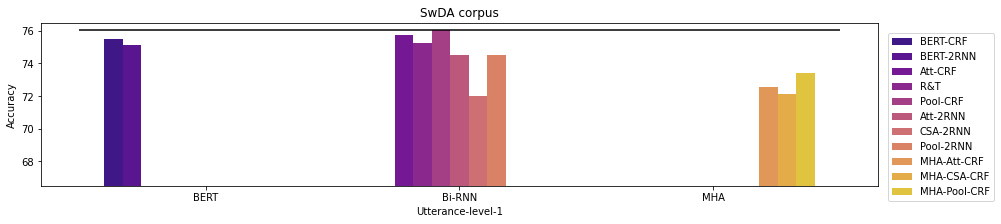

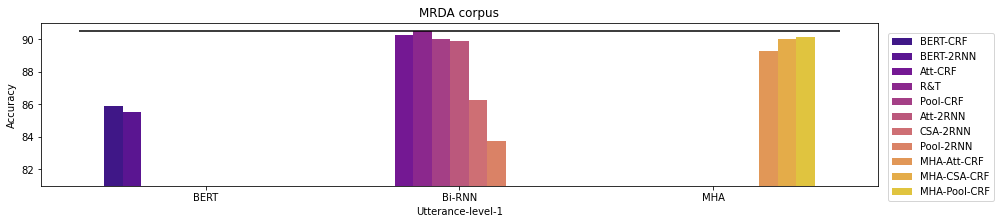

In [102]:
plt.figure(figsize=(15,3))
swda_accuracies =swda_accuracies.sort_values('Utterance-level-1', ascending = True)
sns.barplot(swda_accuracies['Utterance-level-1'], swda_accuracies['Accuracy'], hue = swda_accuracies['Method'], palette = 'plasma')
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.ylim(66.5,76.5)
plt.hlines(y=76.04, xmin=-0.5, xmax=2.5)
# plt.xlim(-0.5,2.5)
plt.title('SwDA corpus')
plt.savefig('test_image1.png',bbox_inches='tight')

plt.figure(figsize=(15,3))
mrda_accuracies =mrda_accuracies.sort_values('Utterance-level-1', ascending = True)
sns.barplot(mrda_accuracies['Utterance-level-1'], mrda_accuracies['Accuracy'], hue = mrda_accuracies['Method'], palette = 'plasma')
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.ylim(81,91)
plt.hlines(y=90.52, xmin=-0.5, xmax=2.5)
# plt.xlim(-0.5,5)
plt.title('MRDA corpus')
# plt.tight_layout()
plt.savefig('test_image2.png',bbox_inches='tight')

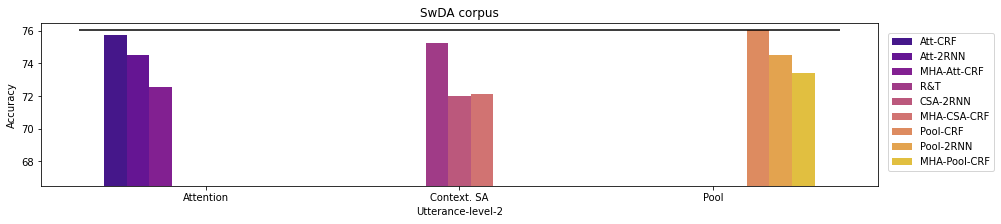

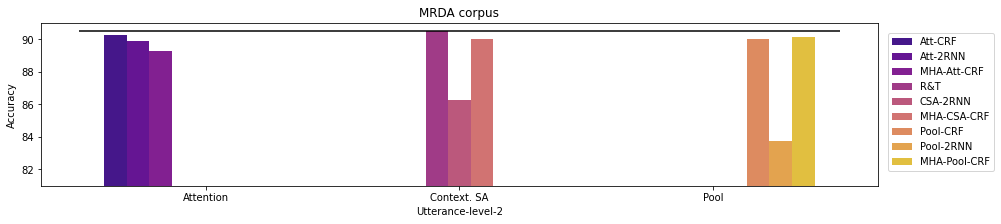

In [103]:
plt.figure(figsize=(15,3))
swda_accuracies =swda_accuracies.sort_values('Utterance-level-2', ascending = True)
new_swda = swda_accuracies[swda_accuracies['Utterance-level-2'] != '-']
sns.barplot(new_swda['Utterance-level-2'], new_swda['Accuracy'], hue = new_swda['Method'], palette = 'plasma')
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.ylim(66.5,76.5)
plt.hlines(y=76.04, xmin=-0.5, xmax=2.5)
# plt.xlim(-0.5,2.5)
plt.title('SwDA corpus')
plt.savefig('test_image3.png',bbox_inches='tight')

plt.figure(figsize=(15,3))
mrda_accuracies =mrda_accuracies.sort_values('Utterance-level-2', ascending = True)
new_mrda = mrda_accuracies[mrda_accuracies['Utterance-level-2'] != '-']
sns.barplot(new_mrda['Utterance-level-2'], new_mrda['Accuracy'], hue = new_mrda['Method'], palette = 'plasma')
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.ylim(81,91)
plt.hlines(y=90.52, xmin=-0.5, xmax=2.5)
# plt.xlim(-0.5,5)
plt.title('MRDA corpus')
# plt.tight_layout()
plt.savefig('test_image4.png',bbox_inches='tight')

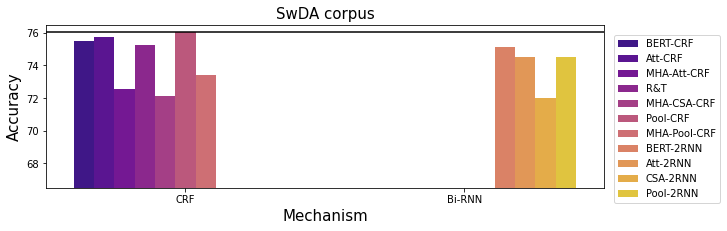

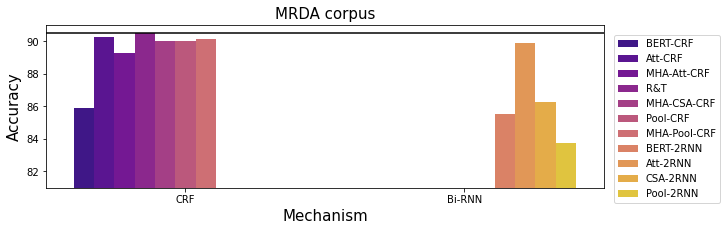

In [120]:
plt.figure(figsize=(10,3))
swda_accuracies =swda_accuracies.sort_values('DA-level', ascending = False)
sns.barplot(swda_accuracies['DA-level'], swda_accuracies['Accuracy'], hue = swda_accuracies['Method'], palette = 'plasma')
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.ylim(66.5,76.5)
plt.hlines(y=76.04, xmin=-0.5, xmax=1.5)
plt.xlim(-0.5,1.5)
plt.title('SwDA corpus', fontsize = 15)
plt.xlabel('Mechanism', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)

# plt.tight_layout()
plt.savefig('test_image4.png',bbox_inches='tight')

plt.figure(figsize=(10,3))
mrda_accuracies =mrda_accuracies.sort_values('DA-level', ascending = False)
sns.barplot(mrda_accuracies['DA-level'], mrda_accuracies['Accuracy'], hue = mrda_accuracies['Method'], palette = 'plasma')
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.ylim(81,91)
plt.hlines(y=90.52, xmin=-0.5, xmax=1.5)
plt.xlim(-0.5,1.5)
plt.title('MRDA corpus', fontsize = 15)
plt.xlabel('Mechanism', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
# plt.tight_layout()
plt.savefig('test_image5.png',bbox_inches='tight')

In [30]:
swda_accuracies['Corpus'] = 'SwDA'
mrda_accuracies['Corpus'] = 'MRDA'
swda_mrda_compare = pd.concat([swda_accuracies,mrda_accuracies])

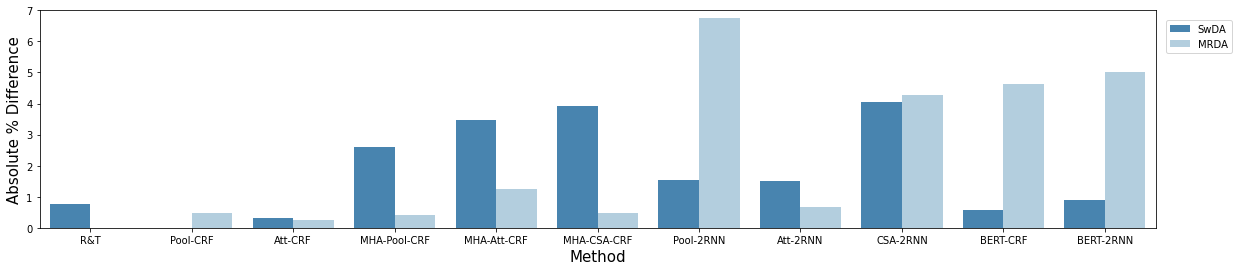

In [56]:
plt.figure(figsize=(20,4))
# mrda_accuracies =mrda_accuracies.sort_values('Architecture', ascending = True)
sns.barplot(swda_mrda_compare['Method'], swda_mrda_compare['Relative accuracies'], hue = swda_mrda_compare['Corpus'], 
            palette = 'Blues_r', order = ['R&T','Pool-CRF','Att-CRF', 'MHA-Pool-CRF', 'MHA-Att-CRF', 'MHA-CSA-CRF','Pool-2RNN',  'Att-2RNN','CSA-2RNN',  'BERT-CRF', 'BERT-2RNN'])
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
# plt.ylim(81,91)
# plt.hlines(y=90.27, xmin=-0.5, xmax=1.5)
# plt.xlim(-0.5,1.5)
plt.ylabel('Absolute % Difference', fontsize=15)
plt.xlabel('Method', fontsize = 15)
plt.ylim(0,7)
plt.savefig('fig5.4.png',bbox_inches='tight')

### Correlation previous and current

In [243]:
from scipy.stats import entropy

In [254]:
def get_prev_curr_df(metadata, predictions, test_y):

    index_to_label = metadata['index_to_label']
    label_to_index = metadata['label_to_index']
    num_da_tags = metadata['num_da_tags']

    label_pred = []
    label_true = []

    for i in range(0,len(predictions)):
        for j in range(0,len(predictions[i])):
            pred = index_to_label[np.argmax(predictions[i][j])]
            label_pred.append(pred)

            true = index_to_label[np.argmax(test_y[i][j])]
            label_true.append(true)

    df_overview = pd.DataFrame({'True': label_true, "Pred": label_pred})

    df_overview['Correct'] = 2
    for i in range(0,len(df_overview)):
        if df_overview.iloc[i,0] == df_overview.iloc[i,1]:
            df_overview.iloc[i,2] = 1
        else:
            df_overview.iloc[i,2] = 0
    return df_overview

def entropy1(labels, base=None):
    value,counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)


def corr_and_df(tags, df):
    prev_labels_entr = []
    label_rec = []
    label_prec = []

    for i in range(0,len(tags)):
        # for a DA (here: fo_o_fw_"_by_bc) see what are the indices that they occured
        # get these indices and remove if it is the zero element
        DA_index = list(df[df['True'] == tags[i]].index)
        DA_index = [i for i in DA_index if i !=0]

        # get the index of the previous labels before the given DA
        prev_DA_index = [i-1 for i in DA_index]

        # get list of previous DA labels
        prev_DA = list(df.loc[prev_DA_index]['True'])

        # get entropy of previous labels
        label_entr = entropy1(prev_DA)
        label_recall = df[df['True'] == tags[i]]['Correct'].sum() / len(df[df['True'] == tags[i]])
        label_precision = df[df['Pred'] == tags[i]]['Correct'].sum() / len(df[df['Pred'] == tags[i]])

        prev_labels_entr.append(label_entr)
        label_rec.append(label_recall)
        label_prec.append(label_precision)

    prev_curr = pd.DataFrame({'label': tags,
    'prev_label_entr': prev_labels_entr,
    'label_recall': label_rec,
    'label_precision': label_prec})


    F1_score = (2 * prev_curr['label_recall']* prev_curr['label_precision']) / (prev_curr['label_recall'] + prev_curr['label_precision'])
    prev_curr['F1'] = F1_score

    corr = prev_curr.iloc[:,[1,4]].corr(method='pearson')
    
    return prev_curr, corr


In [244]:
mrda_df = get_prev_curr_df(metadata_mrda, predictions_mrda, test_y_mrda)
swda_df = get_prev_curr_df(metadata_swda, predictions_swda, test_y_swda)

In [302]:
labels = []
for j in range(0,len(test_y_swda)):
    for i in range(0,len(test_y_swda[j])):
        labels.append(index_to_label[np.argmax(test_y_swda[j][i])])

tags_swda = list(dict(Counter(labels).most_common(18)).keys())

tags_mrda = list(da_dict.keys())

In [306]:
swda_overview = corr_and_df(tags_swda, swda_df)[0]

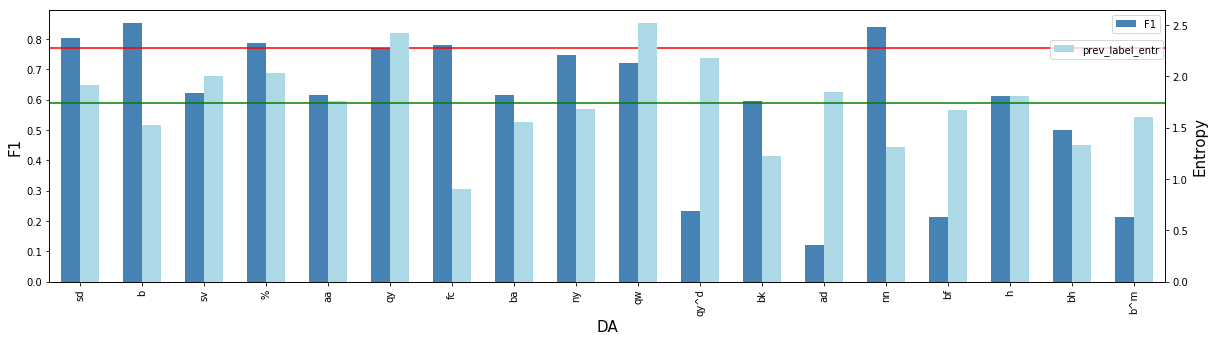

In [365]:
fig = plt.figure(figsize=(20,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

# df.amount.plot(kind='bar', color='red', ax=ax, width=width, position=1)
# df.price.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
swda_overview.plot(x="label", y="prev_label_entr", ax=ax2, legend=False, color="lightblue", kind ='bar', position=0, width = 0.3)
swda_overview.plot(x="label", y="F1", ax=ax,position=1, legend=True, color = 'steelblue',kind = 'bar', width = 0.3)

ax.set_ylabel('F1', fontsize = 15)
ax.set_xlabel('DA', fontsize = 15)
ax.hlines(0.7686, -0.5,17.5, color = 'red')
ax2.set_ylabel('Entropy', fontsize = 15)
ax2.hlines(1.74, -0.5,17.5, color = 'green')

plt.legend(bbox_to_anchor = (0.87,1), loc = 2, borderaxespad = 3.)
# ax2.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.xlim(-0.5,17.5)
plt.show()
fig.savefig('swda_entropy.png',bbox_inches='tight')

In [287]:
mrda_overview = corr_and_df(tags_mrda, mrda_df)[0]

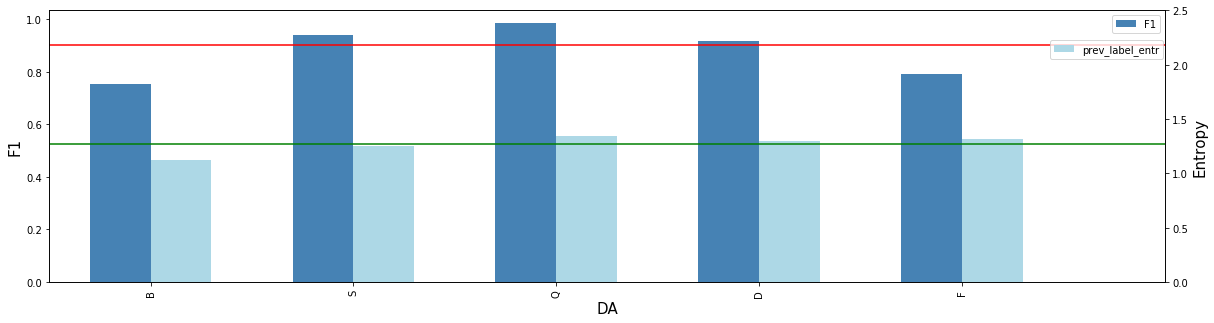

In [366]:
fig = plt.figure(figsize=(20,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

# df.amount.plot(kind='bar', color='red', ax=ax, width=width, position=1)
# df.price.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
mrda_overview.plot(x="label", y="prev_label_entr", ax=ax2, legend=False, color="lightblue", kind ='bar', position=0, width = 0.3)
mrda_overview.plot(x="label", y="F1", ax=ax,position=1, legend=True, color = 'steelblue',kind = 'bar', width = 0.3)

ax.set_ylabel('F1', fontsize = 15)
ax.set_xlabel('DA', fontsize = 15)
ax.hlines(0.9021, -0.5,5, color = 'red')
ax2.set_ylabel('Entropy', fontsize = 15)
ax2.set_ylim(0.0,2.5)
ax2.hlines(1.27, -0.5,5, color = 'green')

plt.legend(bbox_to_anchor = (0.87,1), loc = 2, borderaxespad = 3.)
# ax2.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.xlim(-0.5,5)
plt.show()
fig.savefig('mrda_entropy.png',bbox_inches='tight')

(-1, 5)

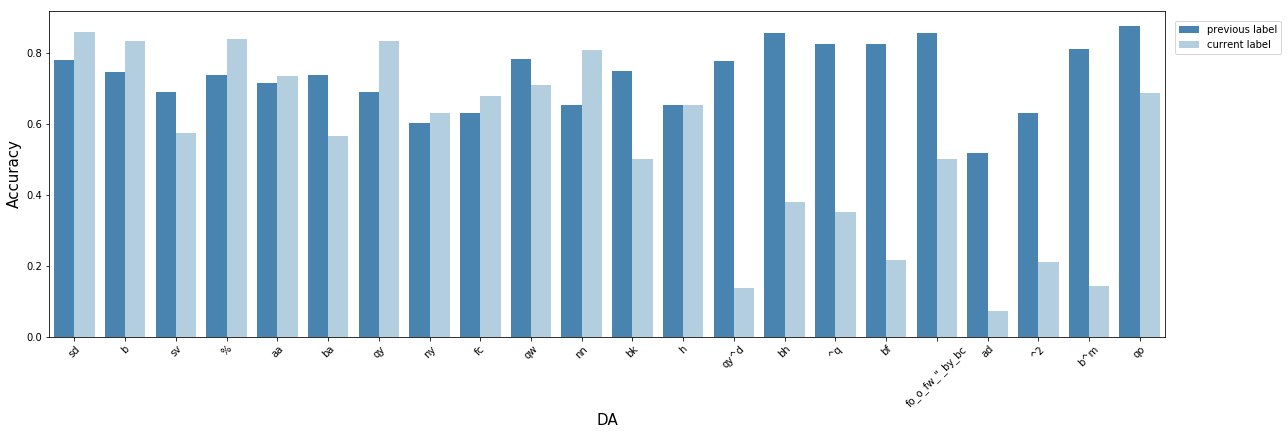

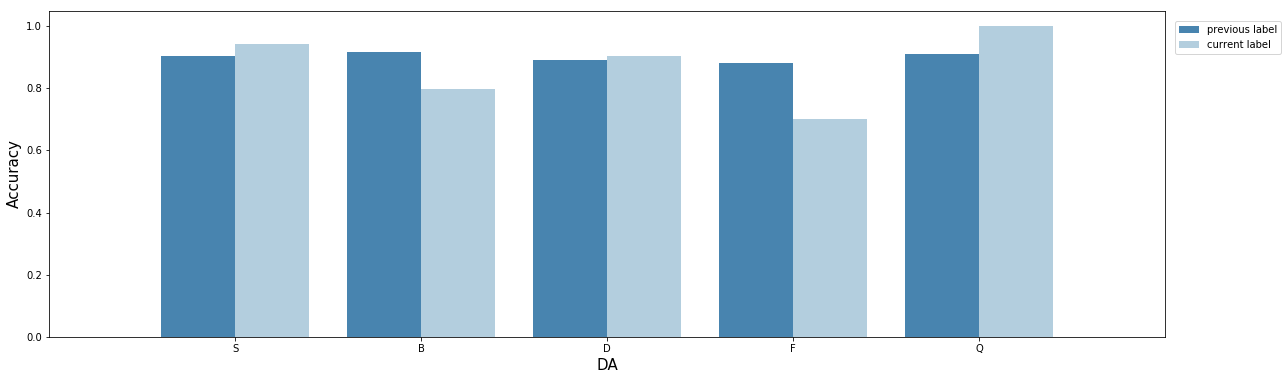

In [140]:
# swda_df = get_prev_curr_df(metadata_swda, predictions_swda, test_y_swda)[0]

plt.figure(figsize=(20,6))
sns.barplot(x = test_df['labels'], y = test_df['accuracy'], hue=test_df['hue1'],palette = 'Blues_r' )
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.xticks(rotation=45)
plt.xlabel('DA', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
# plt.xlim(-1,25)


plt.figure(figsize=(20,6))
sns.barplot(x = mrda_df['labels'], y = mrda_df['accuracy'], hue=mrda_df['hue1'] ,palette = 'Blues_r')
plt.legend(bbox_to_anchor = (1,1), loc = 2, borderaxespad = 1.)
plt.xlabel('DA', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.xlim(-1,5)